In [1]:
!pip install -U finance-datareader

In [2]:
import pandas as pd
import pandas_datareader as pdr
import FinanceDataReader as fdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
import time
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [3]:
%matplotlib inline
#데이터 생성과 화면 표시를 위한 라이브러리 호출
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [4]:
'''import FinanceDataReader as fdr

# 한국거래소 상장종목 전체
df_krx = fdr.StockListing('KRX')
df_krx.head()'''

"import FinanceDataReader as fdr\n\n# 한국거래소 상장종목 전체\ndf_krx = fdr.StockListing('KRX')\ndf_krx.head()"

In [5]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)
        self.scaler = MinMaxScaler()
        self.data = fdr.DataReader(self.symbol, self.start, self.end)#주식 6가지 특징, 고,시,저,종,거,변
        df_gold = pdr.DataReader('GOLDAMGBD228NLBM', 'fred', start=self.start, end=self.end)#금값
        df_du = pdr.DataReader('POILDUBUSDM', 'fred', start=self.start, end=self.end)#석유
        df_kospi = fdr.DataReader('KS11', self.start, self.end)#코스피
        df_dollar = fdr.DataReader('USD/KRW', self.start, self.end)#원달러환율

        #gold 채우기
        df_gold = df_gold.fillna(value=-1)
        gold = []
        for i in df_gold.values:
            gold.append(i[0])

        check = min(gold)
        for i in range(0,len(gold)):
            if gold[i] == -1:
                gold[i] = check
            else:
                check = gold[i]
        #oil 채우기
        du = df_du.values
        ddu = []
        check = int(list(start)[1])
        c = 0
        for i in self.data.index:
            if i.month == check:
                ddu.append(du[c][0])
            else:
                check += 1
                if check >= 13:
                    check = 1
                c += 1
                if c >= len(du):
                    break
                ddu.append(du[c][0])
        
        self.data['dollar'] = df_dollar[['Close']]
        self.data['kospi'] = df_kospi[['Close']]
        self.data['oil'] = pd.DataFrame(data=ddu, index=self.data.index, columns=['oil'])
        self.data['gold'] = pd.DataFrame(data=gold, index=df_gold.index, columns=['gold'])
        print('len:',len(self.data.index))
        self.data = pd.DataFrame(self.scaler.fit_transform(self.data))
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        #data = data.apply(lambda x: x//10000)
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [6]:
class GRU(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(GRU, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn
        self.gru = nn.GRU(self.input_dim, self.hidden_dim*2, self.num_layers)
        self.gru2 = nn.GRU(self.hidden_dim*2, self.hidden_dim, self.num_layers)
        self.regressor = self.make_regressor()

    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim//2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim//2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        x, _ = self.gru(x)
        x, _ = self.gru2(x)
        y_pred = self.regressor(x[-1].view(self.batch_size, -1))
        return y_pred

In [7]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

In [8]:
def train(model, trainset, optimizer, loss_fn, args):
    trainloader = DataLoader(trainset, 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 3].float().to(args.device)
        #print(torch.max(X[:, :, 3]), torch.max(y_true))

        model.zero_grad()
        optimizer.zero_grad()

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [9]:
def validate(model, valset, loss_fn, args):
    valloader = DataLoader(valset, 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]
    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [10]:
def experiment(trainset,valset, model,args,min_val):

    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, trainset, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, valset, loss_fn, args)
        te = time.time()
        if val_acc < min_val:
            min_val = val_acc
            torch.save(model.state_dict(), '/content/gdrive/My Drive/GRUmodel/GRU_Best_model.pt')
            print('Best model saved')
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    return vars(args), result, min_val

In [11]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
#삼성전자,Sk하이닉스,네이버,LG화학,셀트리온,현대차,카카오,삼성SDI,LG생활건강,현대모비스
#SK텔레콤,NC소프트,기아차,포스코,KB금융,SK,LG전자,LG,한국전력,삼성생명
args.symbol = ['005930','000660','035420','051910','068270','005380','035720','006400','051900','012330',
               '017670','036570','000270','005490','105560','034730','066570','003550','015760']#,'032830']
args.batch_size = 128
args.x_frames = 7
args.y_frames = 7



In [12]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [27]:

# ====== Model Capacity ===== #
args.input_dim = 10
args.hid_dim = 64
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.5
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.001
args.epoch = 30


model = GRU(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
best_model = GRU(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
min_val = 100
print(args)

valset = StockDataset('030200', args.x_frames,args.y_frames,(2001,1,1), (2020,8,1))

for sb in args.symbol:
    trainset = StockDataset(sb, args.x_frames,args.y_frames,(2011,1,1), (2020,8,1))    
    setting, result,min_val = experiment(trainset, valset, model,deepcopy(args),min_val)

Namespace(batch_size=128, device='cuda', dropout=0.5, epoch=30, hid_dim=64, input_dim=10, l2=1e-05, lr=0.001, n_layers=2, optim='Adam', symbol=['005930', '000660', '035420', '051910', '068270', '005380', '035720', '006400', '051900', '012330', '017670', '036570', '000270', '005490', '105560', '034730', '066570', '003550', '015760'], use_bn=True, x_frames=7, y_frames=7)
len: 4841
len: 2361
Best model saved
Epoch 0, Acc(train/val): 32.67/32.11, Loss(train/val) 0.11364/0.10792. Took 0.44 sec
Best model saved
Epoch 1, Acc(train/val): 26.05/27.79, Loss(train/val) 0.04801/0.05949. Took 0.45 sec
Best model saved
Epoch 2, Acc(train/val): 21.53/14.15, Loss(train/val) 0.03476/0.02347. Took 0.44 sec
Epoch 3, Acc(train/val): 19.14/33.76, Loss(train/val) 0.02538/0.13820. Took 0.44 sec
Epoch 4, Acc(train/val): 17.12/48.65, Loss(train/val) 0.02126/0.20064. Took 0.48 sec
Epoch 5, Acc(train/val): 15.47/57.81, Loss(train/val) 0.01759/0.24653. Took 0.43 sec
Epoch 6, Acc(train/val): 14.89/71.44, Loss(trai

In [28]:
testinput = StockDataset('030200',args.x_frames,args.y_frames,(2001,1,1),(2020,8,1))
testloader = DataLoader(testinput, batch_size=args.batch_size, shuffle=False, drop_last=True)

print(len(testloader))

len: 4841
37


In [29]:

result = []
result2 = []
for i, (X,y) in enumerate(testloader):

    model.eval()
    X = X.transpose(0, 1).float().to(args.device)
    y_true = y[:, :, 3].float().to(args.device)

    y_pred = model(X)
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    y_pred = y_pred.cpu().detach().numpy()
    y_true = y_true.cpu().detach().numpy()
    result.extend(y_pred)
    result2.extend(y_true)


In [30]:
best_model.load_state_dict(torch.load('/content/gdrive/My Drive/GRUmodel/GRU_Best_model.pt'))
best_model.to(args.device)
result3 = []
for i, (X,y) in enumerate(testloader):

    best_model.eval()
    X = X.transpose(0, 1).float().to(args.device)
    y_true = y[:, :, 3].float().to(args.device)

    y_pred = best_model(X)
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    y_pred = y_pred.cpu().detach().numpy()
    result3.extend(y_pred)


In [31]:
model == best_model

False

Text(0.5, 1.0, 'pred vs real')

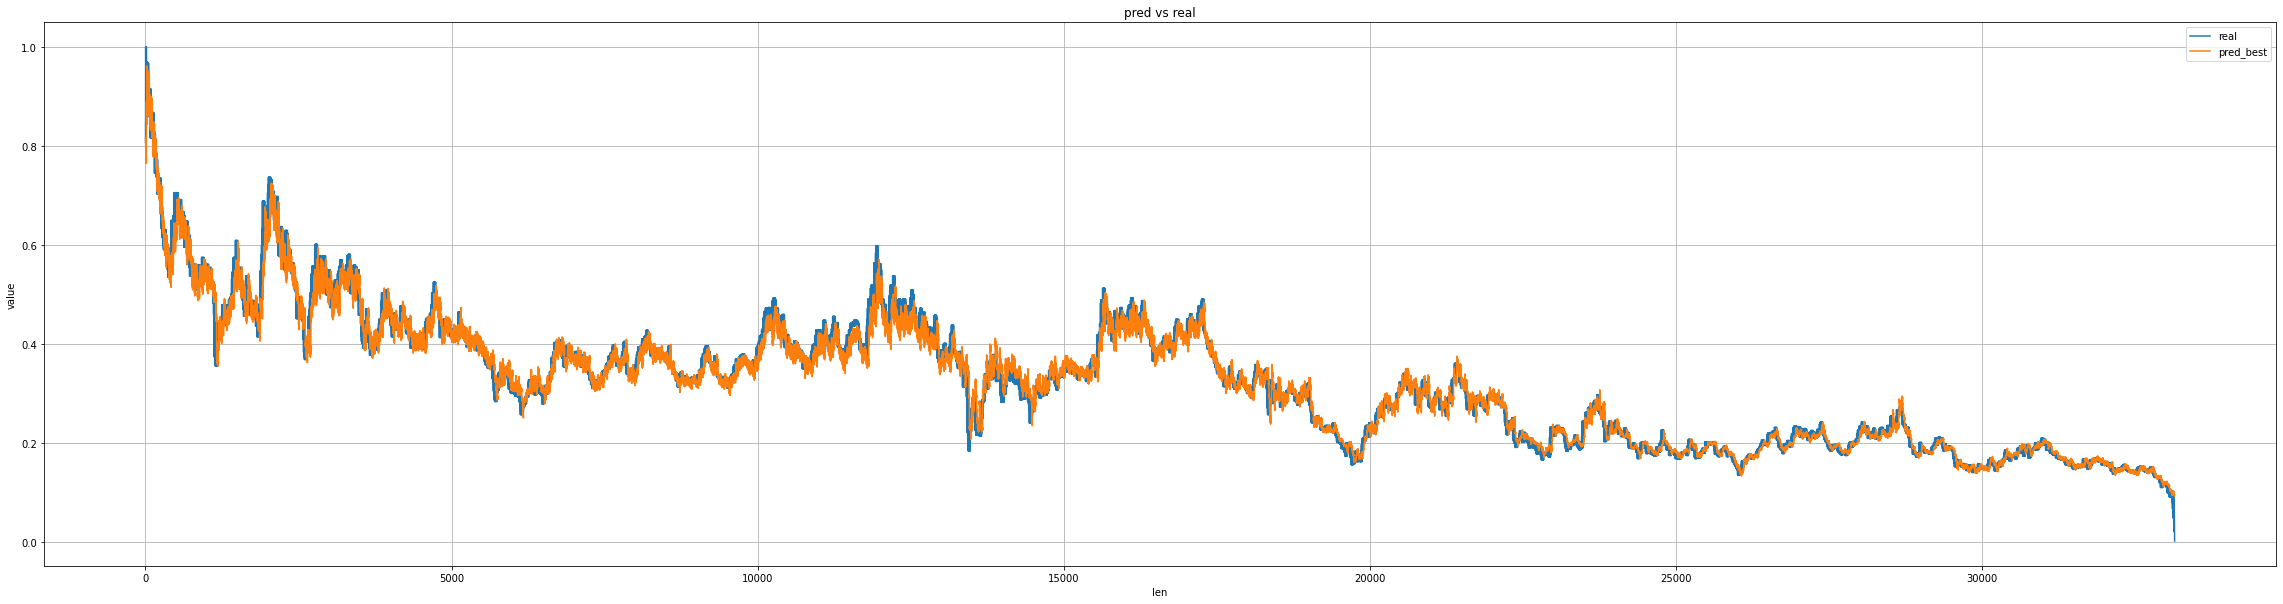

In [32]:
fig = plt.figure(figsize=(40,10))
xl = [n for n in range(1,len(result)+1)]


# ====== test plot ====== #
ax = fig.add_subplot(1, 1, 1)
ax.plot(xl, result2,  label='real')
ax.plot(xl, result3,  label='pred_best')
ax.set_xlabel('len')
ax.set_ylabel('value')
ax.grid()
ax.legend()
ax.set_title('pred vs real')

In [33]:
'''
from google.colab import drive
drive.mount('/content/gdrive')

modelPath = '/content/gdrive/My Drive/GRU_batch_128_model.pt'
torch.save(model.state_dict(), modelPath)
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n\nmodelPath = '/content/gdrive/My Drive/GRU_batch_128_model.pt'\ntorch.save(model.state_dict(), modelPath)\n"